# DataFrame API

In [3]:
import findspark
findspark.init()
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [4]:
from pyspark.sql.types import StructType

schema = StructType([])
emptyDf = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)

In [5]:
emptyDf.printSchema()

root



In [6]:
spark.range(0, 10, 2).show()

+---+
| id|
+---+
|  0|
|  2|
|  4|
|  6|
|  8|
+---+



In [8]:
from pyspark.sql import functions as F
spark.range(1).select(F.current_date()).show()

+--------------+
|current_date()|
+--------------+
|    2021-10-07|
+--------------+



In [10]:
import os
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))

In [11]:
tDf.columns

['_c0', '_c1', '_c2']

In [12]:
tDf = tDf.withColumn("id", tDf._c0.cast("integer"))
tDf = tDf.withColumn("height", tDf['_c1'].cast("double"))
tDf = tDf.withColumn("weight", tDf['_c2'].cast("double"))

In [13]:
tDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: double (nullable = true)
 |-- _c2: double (nullable = true)
 |-- id: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



In [14]:
tDf = tDf.drop('_c0').drop('_c1').drop('_c2')

In [15]:
tDf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- height: double (nullable = true)
 |-- weight: double (nullable = true)



In [16]:
tDf.take(1)

[Row(id=1, height=65.78, weight=112.99)]

In [17]:
myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('data','myDf.csv'))

In [18]:
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- age: integer (nullable = true)



In [19]:
myDf.show()

+---+----+---+
|_c0|name|age|
+---+----+---+
|  0| js1| 10|
|  1| js2| 20|
+---+----+---+



In [20]:
def uppercase(s):
    return s.upper()

In [21]:
uppercase("a")

'A'

In [22]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

upperUdf = udf(uppercase, StringType())

In [23]:
myDf = myDf.withColumn("nameUpper", upperUdf(myDf['name']))

In [25]:
myDf.show()

+---+----+---+---------+
|_c0|name|age|nameUpper|
+---+----+---+---------+
|  0| js1| 10|      JS1|
|  1| js2| 20|      JS2|
+---+----+---+---------+



In [28]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

toDoublefunc = udf(lambda x: float(x), DoubleType())
myDf = myDf.withColumn("ageD", toDoublefunc(myDf.age))

In [29]:
myDf.dtypes

[('_c0', 'int'),
 ('name', 'string'),
 ('age', 'int'),
 ('nameUpper', 'string'),
 ('heightD', 'double'),
 ('ageD', 'double')]

In [32]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

height_udf = udf(lambda age: "older" if age >=10 else "younger", StringType())
heightDf=myDf.withColumn("age>10", height_udf(myDf.heightD))

In [33]:
heightDf.show()

+---+----+---+---------+-------+----+------+
|_c0|name|age|nameUpper|heightD|ageD|age>10|
+---+----+---+---------+-------+----+------+
|  0| js1| 10|      JS1|   10.0|10.0| older|
|  1| js2| 20|      JS2|   20.0|20.0| older|
+---+----+---+---------+-------+----+------+



In [34]:
tDf=tDf.withColumnRenamed('id','ID')

In [35]:
tDf.show(3)

+---+------+------+
| ID|height|weight|
+---+------+------+
|  1| 65.78|112.99|
|  2| 71.52|136.49|
|  3|  69.4|153.03|
+---+------+------+
only showing top 3 rows



# 그래프

In [36]:
_weightRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
_heightRdd=tDf.rdd.map(lambda fields:fields[2]).collect()

In [37]:
import numpy as np
print (np.array(_weightRdd)[:5])
print (np.array(_heightRdd)[:5])

[65.78 71.52 69.4  68.22 67.79]
[112.99 136.49 153.03 142.34 144.3 ]


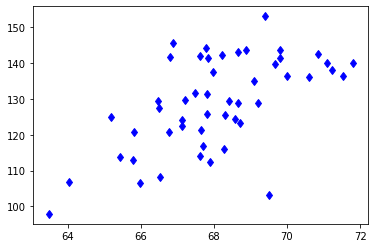

In [43]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(_weightRdd), np.array(_heightRdd),'bd')
plt.show()

### boxplot, viloinplot

In [44]:
height = tDf.select("height").toPandas()

In [45]:
height.describe()

,height
count,50.00000
mean,68.05240
std,1.82398
min,63.48000
25%,66.94000
50%,67.86500
75%,69.18000
max,71.80000


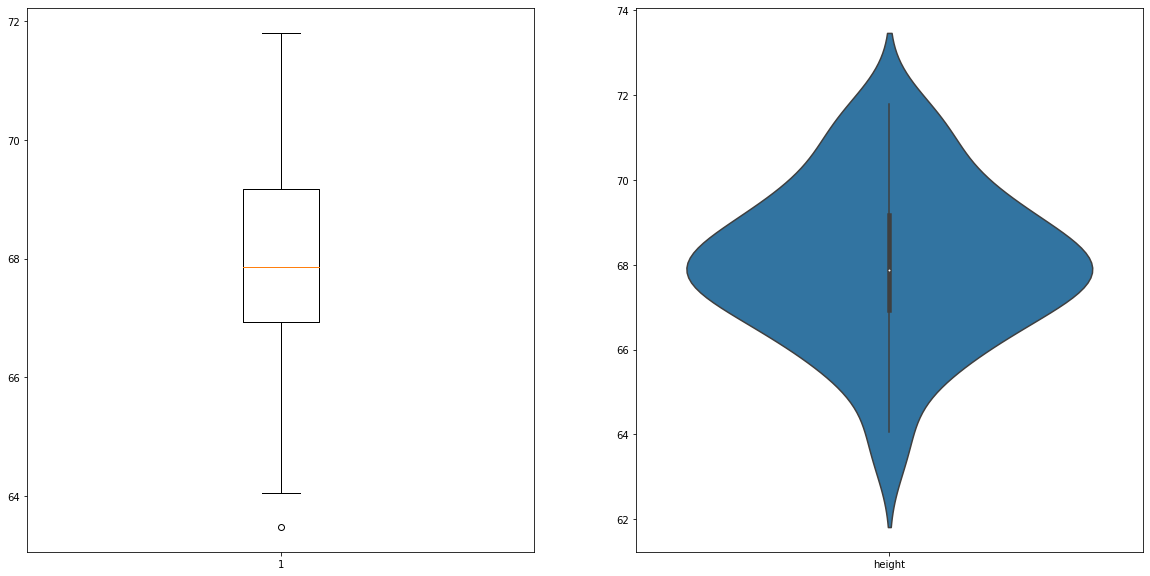

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)  # subplot location
ax1 = plt.boxplot(height)

ax2 = fig.add_subplot(1, 2, 2)
ax2 = sns.violinplot(data=height)